In [12]:
# Pre-train용
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-8]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("output1.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Pre-trained.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 및 데이터로더 생성
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = 0.8
train_dataset, val_dataset = train_test_split(dataset, test_size=1-train_size, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 옵티마이저 및 학습률 설정
# 기본 학습률 : 2e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 에폭 설정
epochs = 10

# 학습 루프
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs[1]  # loss가 outputs의 두 번째 값입니다.
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}')
        # hidden state를 저장합니다.
        #hidden_states = outputs[2]
        #hidden_states_list.append(hidden_states)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}')

# 모든 에폭에 대한 hidden state를 합쳐서 CSV 파일로 저장합니다.
#hidden_states_concat = torch.cat(hidden_states_list, dim=0)
#hidden_states_concat = hidden_states_concat[:, 0, :].cpu().detach().numpy()
#hidden_states_df = pd.DataFrame(hidden_states_concat)
#hidden_states_df.to_csv("hidden_states_all_epochs.csv", index=False)

# 모델 저장
torch.save(model.state_dict(), model_path)

# 모델 평가
model.eval()
val_accuracy = 0
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()

print(f'Validation Accuracy: {val_accuracy / len(val_dataloader)}')


KeyboardInterrupt: 

In [11]:
# Fine-tune용
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-8]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("output5.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 불러오는 경로
model_path = "Pre-trained.pt"
# 모델 저장경로
model_path2 = "Fine-tuned.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path))
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 및 데이터로더 생성
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = 0.8
train_dataset, val_dataset = train_test_split(dataset, test_size=1-train_size, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 옵티마이저 및 학습률 설정
# 기본 학습률 : 2e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)

# 에폭 설정
epochs = 10

# 학습 루프
hidden_states_list = []  # 모든 에폭에 대한 hidden state를 저장할 리스트
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs[1]  # loss가 outputs의 두 번째 값입니다.
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}')
        # hidden state를 저장합니다.
        #hidden_states = outputs[2]
        #hidden_states_list.append(hidden_states)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}')

# 모든 에폭에 대한 hidden state를 합쳐서 CSV 파일로 저장합니다.
#hidden_states_concat = torch.cat(hidden_states_list, dim=0)
#hidden_states_concat = hidden_states_concat[:, 0, :].cpu().detach().numpy()
#hidden_states_df = pd.DataFrame(hidden_states_concat)
#hidden_states_df.to_csv("hidden_states_all_epochs.csv", index=False)

# 모델 저장
torch.save(model.state_dict(), model_path2)

# 모델 평가
model.eval()
val_accuracy = 0
for batch in val_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()

print(f'Validation Accuracy: {val_accuracy / len(val_dataloader)}')


X_train
 ['3/23/1963, nan, 999-45-1210, S99916197, X23361434X, Mrs., Malia984, Barrows492, nan, Wolf938, M, asian, nonhispanic, F, Hanoi  Hà Đông  VN, 693 Hettinger Underpass Unit 8, Shrewsbury, Massachusetts, Worcester County, nan, 42.3182333, -71.68403957, 1456657.22, 7867.64, 11/11/1974, nan, 82bec8e4-6c53-4af4-acbf-80f3cf64f756, 40055000.0, Chronic sinusitis (disorder), Miscarriage in first trimester, Body mass index 30+ - obesity (finding), Nasal congestion (finding), Chill (finding), Fever (finding), Loss of taste (finding)', '3/2/1966, nan, 999-86-8438, S99986421, X56721264X, Mr., Adam631, Wiegand701, nan, nan, M, white, nonhispanic, M, Boston  Massachusetts  US, 822 Rosenbaum Green Apt 60, Malden, Massachusetts, Middlesex County, 2155.0, 42.47884498, -71.03499439, 33743.09, 500.5, 3/12/2008, nan, 586916e9-2a18-45be-88bf-28355e86b749, 162864005.0, Body mass index 30+ - obesity (finding), Prediabetes, Anemia (disorder), Sputum finding (finding), Fever (finding)', '12/10/1997, nan

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Pre-train model loaded.
True
Epoch 1/3, Batch Loss: 0.021415866911411285
Epoch 1/3, Batch Loss: 0.2512178421020508
Epoch 1/3, Batch Loss: 0.028070129454135895
Epoch 1/3, Batch Loss: 0.006695822812616825
Epoch 1/3, Batch Loss: 0.009960749186575413
Epoch 1/3, Batch Loss: 0.538854718208313
Epoch 1/3, Batch Loss: 0.3747574985027313
Epoch 1/3, Batch Loss: 0.513851523399353
Epoch 1/3, Batch Loss: 0.6325418949127197
Epoch 1/3, Batch Loss: 0.4528624713420868
Epoch 1/3, Batch Loss: 0.8795053958892822
Epoch 1/3, Batch Loss: 0.012876220978796482
Epoch 1/3, Batch Loss: 0.3066244423389435
Epoch 1/3, Batch Loss: 0.03363512456417084
Epoch 1/3, Batch Loss: 0.35334575176239014
Epoch 1/3, Batch Loss: 0.02682681195437908
Epoch 1/3, Batch Loss: 0.29566988348960876
Epoch 1/3, Batch Loss: 0.6735883951187134
Epoch 1/3, Batch Loss: 0.023419097065925598
Epoch 1/3, Batch Loss: 0.5191982984542847
Epoch 1/3, Batch Loss: 0.2912901043891907
Epoch 1/3, Batch Loss: 0.3968028426170349
Epoch 1/3, Batch Loss: 0.17576363

In [ ]:
# 데이터 랜덤분할(100/500)
import pandas as pd

def sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500):
    # CSV 파일을 읽어옵니다.
    data = pd.read_csv(input_file)
    
    # 데이터를 랜덤하게 샘플링합니다.
    sampled_data_500 = data.sample(n=n_500, random_state=42)
    
    # 샘플링된 500개의 데이터를 CSV 파일로 내보냅니다.
    sampled_data_500.to_csv(output_file_500, index=False)
    
    # sampled_data_500에서 첫 100개의 데이터를 선택합니다.
    sampled_data_100 = sampled_data_500.head(300)
    
    # 선택된 첫 100개의 데이터를 CSV 파일로 내보냅니다.
    sampled_data_100.to_csv(output_file_100, index=False)

# 입력 CSV 파일 경로
input_file = "output6.csv"

# 출력 CSV 파일 경로
output_file_500 = "random_500.csv"
output_file_100 = "random_100.csv"

# 랜덤하게 추출할 데이터 개수
n_500 = 500

# 함수 호출
sample_csv_and_additional(input_file, output_file_500, output_file_100, n_500)


In [51]:
# smashed data 생성 (500/server side)
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-5]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("random_500.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Pre-trained.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path))
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 생성
dataset = TensorDataset(input_ids, attention_masks, labels)

# 데이터로더 생성
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 모델 평가
model.eval()
val_accuracy = 0
hidden_states_list = []  # 평가할 때 hidden state를 저장할 리스트
for batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()
    # hidden state를 저장합니다.
    hidden_states = outputs[2]
    hidden_states_list.append(hidden_states)
hidden_states_concat = torch.cat(hidden_states_list, dim=0)
hidden_states_concat = hidden_states_concat[:, 0, :].cpu().detach().numpy()
hidden_states_df = pd.DataFrame(hidden_states_concat)
hidden_states_df.to_csv("Dictionary_smashed_data.csv", index=False)

print(f'Validation Accuracy: {val_accuracy / len(dataloader)}')


X_train
 ['6/6/1971, nan, 999-71-5643, S99989143, X60757569X, Mr., Tracy345, Skiles927, nan, nan, M, white, nonhispanic, M, Marblehead  Massachusetts  US, 884 Auer Annex, Uxbridge, Massachusetts, Worcester County, nan, 42.10399442, -71.60337809, 1307003.54, 4997.12, 6/5/1974, nan, 5921ab74-99b6-49c9-a7d3-ad8349070ca8, 128613002.0, Seizure disorder, History of single seizure (situation), Hypertension, Body mass index 30+ - obesity (finding), Cough (finding), Sore throat symptom (finding), Viral sinusitis (disorder)', '10/28/1915, 3/3/1990, 999-77-6721, S99996606, X31277871X, Mrs., Londa304, Hessel84, nan, Weimann465, M, white, nonhispanic, F, Somerville  Massachusetts  US, 136 Ratke Manor, Dighton, Massachusetts, Bristol County, nan, 41.81765972, -71.18273423, 1416726.1, 356060.14, 12/21/1933, nan, e9e9254b-75fb-4c28-8694-4ac7c5d8f076, 59621000.0, Hypertension, Cardiac Arrest, History of cardiac arrest (situation), Prediabetes, Anemia (disorder), Smokes tobacco daily, Atrial Fibrillatio

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Pre-train model loaded.


C:\Users\MCC\anaconda3\envs\biotf\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


True
Validation Accuracy: 0.880859375


In [73]:
# smashed data 생성 (100/client side)
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        labels=None,
        output_hidden_states=True
    ):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            labels=labels,
            output_hidden_states=output_hidden_states
        )
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-5]  # n번째 레이어의 hidden states를 반환합니다.
        loss = outputs.loss
        return logits, loss, hidden_states

# 데이터 로드 및 전처리
data_A = pd.read_csv("random_300.csv")  # data set A 파일명에 맞게 수정
data_B = pd.read_csv("infected.csv")  # data set B 파일명에 맞게 수정
# 모델 저장 경로
model_path = "Fine-tuned.pt"

# X_train, Y_train 생성
X_train = []
Y_train = []

for index, row in data_A.iterrows():  # 중복 제거를 하지 않고 원본 데이터 사용
    patient_id = row["ID"]
    patient_info = [str(row[column]) for column in data_A.columns if column != "ID" and column != "DESCRIPTION"]
    symptoms = ", ".join(data_A[data_A["ID"] == patient_id]["DESCRIPTION"].tolist())
    combined_info = ", ".join(patient_info) + ", " + symptoms
    X_train.append(combined_info)
    if patient_id in data_B.values:
        Y_train.append(1)
    else:
        Y_train.append(0)

print("X_train\n", X_train[:10])
print("Y_train\n", Y_train[:10])
        
# BERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 모델이 이미 저장되어 있는지 확인하고, 저장된 모델이 있으면 불러오고 없으면 새로운 모델 생성
if os.path.exists(model_path):
    # 저장된 모델이 있을 경우 불러오기
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.load_state_dict(torch.load(model_path))
    print("Pre-train model loaded.")
else:
    # 저장된 모델이 없을 경우 새로운 모델 생성
    model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    print("New model generated.")

# 입력 데이터를 BERT의 입력 형식으로 변환
max_len = 128  # 입력 시퀀스의 최대 길이

input_ids = []
attention_masks = []

for info in X_train:
    encoded_dict = tokenizer.encode_plus(
                        info,                         # 환자 정보 및 증상
                        add_special_tokens = True,    # [CLS], [SEP] 토큰 추가
                        max_length = max_len,         # 최대 길이 지정
                        pad_to_max_length = True,     # 패딩을 추가하여 최대 길이로 맞춤
                        return_attention_mask = True, # 어텐션 마스크 생성
                        return_tensors = 'pt',        # PyTorch 텐서로 반환
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(Y_train)

# 데이터셋 생성
dataset = TensorDataset(input_ids, attention_masks, labels)

# 데이터로더 생성
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 모델을 GPU로 이동
model.to(device)

# 모델 평가
model.eval()
val_accuracy = 0
hidden_states_list = []  # 평가할 때 hidden state를 저장할 리스트
for batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs[0]  # logits가 outputs의 첫 번째 값입니다.
    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    val_accuracy += (logits.argmax(axis=1) == label_ids).mean().item()
    # hidden state를 저장합니다.
    hidden_states = outputs[2]
    hidden_states_list.append(hidden_states)
hidden_states_concat = torch.cat(hidden_states_list, dim=0)
hidden_states_concat = hidden_states_concat[:, 0, :].cpu().detach().numpy()
hidden_states_df = pd.DataFrame(hidden_states_concat)
hidden_states_df.to_csv("Client_smashed_data.csv", index=False)

print(f'Validation Accuracy: {val_accuracy / len(dataloader)}')


X_train
 ['6/6/1971, nan, 999-71-5643, S99989143, X60757569X, Mr., Tracy345, Skiles927, nan, nan, M, white, nonhispanic, M, Marblehead  Massachusetts  US, 884 Auer Annex, Uxbridge, Massachusetts, Worcester County, nan, 42.10399442, -71.60337809, 1307003.54, 4997.12, 6/5/1974, nan, 5921ab74-99b6-49c9-a7d3-ad8349070ca8, 128613002.0, Seizure disorder, History of single seizure (situation), Hypertension, Body mass index 30+ - obesity (finding), Cough (finding), Sore throat symptom (finding), Viral sinusitis (disorder)', '10/28/1915, 3/3/1990, 999-77-6721, S99996606, X31277871X, Mrs., Londa304, Hessel84, nan, Weimann465, M, white, nonhispanic, F, Somerville  Massachusetts  US, 136 Ratke Manor, Dighton, Massachusetts, Bristol County, nan, 41.81765972, -71.18273423, 1416726.1, 356060.14, 12/21/1933, nan, e9e9254b-75fb-4c28-8694-4ac7c5d8f076, 59621000.0, Hypertension, Cardiac Arrest, History of cardiac arrest (situation), Prediabetes, Anemia (disorder), Smokes tobacco daily, Atrial Fibrillatio

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Pre-train model loaded.


C:\Users\MCC\anaconda3\envs\biotf\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


True
Validation Accuracy: 0.8936403508771931


In [74]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

def read_csv_data(file_paths):
    data = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, header=None)
        data.append(df.values)
    return data

def calculate_similarity(client_data, server_data):
    similarity_scores = cdist(client_data, server_data, metric='euclidean')
    # Invert the distances to convert them into similarities
    similarity_scores = np.reciprocal(similarity_scores + 1e-8)
    return similarity_scores

def get_top_n_inferences(similarity_scores, n):
    top_n_indices = np.argsort(similarity_scores, axis=1)[:, -n:]
    return top_n_indices

def calculate_accuracy(top_n_indices):
    total_clients = len(top_n_indices)
    success_indices = []
    for i, indices in enumerate(top_n_indices):
        if i in indices:
            success_indices.append(i)
    accuracy = len(success_indices) / total_clients
    return accuracy, success_indices

def main(client_files, server_files, n):
    # Read CSV data
    client_data = read_csv_data(client_files)
    server_data = read_csv_data(server_files)

    # Exclude the first row from server data for comparison
    server_data = [data[1:] for data in server_data]
    client_data = [data[1:] for data in client_data]

    # Convert data to numpy arrays
    client_data = np.vstack(client_data)
    server_data = np.vstack(server_data)

    # Calculate similarity
    similarity_scores = calculate_similarity(client_data, server_data)

    # Get top N inferences
    top_n_indices = get_top_n_inferences(similarity_scores, n)

    # Calculate and output top N accuracy
    accuracy, success_indices = calculate_accuracy(top_n_indices)
    print(f"Top@{n} Accuracy: {accuracy * 100:.2f}%")

    # Output Success Indices
    print("Success Indices:", success_indices)

    # Output top N inferences
    for i, indices in enumerate(top_n_indices):
        print(f"\nTop {n} inferences for client {i + 1}:")
        for idx in indices:
            print(f"Server {idx + 1} with similarity score {similarity_scores[i][idx]}")

if __name__ == "__main__":
    client_files = ['Client_smashed_data.csv']
    server_files = ['Dictionary_smashed_data.csv']
    n = 5  # Number of top inferences
    main(client_files, server_files, n)


Top@5 Accuracy: 8.67%
Success Indices: [0, 11, 14, 21, 32, 66, 68, 73, 92, 94, 95, 109, 114, 115, 131, 144, 165, 166, 174, 203, 205, 216, 218, 222, 263, 280]

Top 5 inferences for client 1:
Server 1 with similarity score 0.12358404502513352
Server 74 with similarity score 0.12394459954726277
Server 110 with similarity score 0.12450045602843139
Server 33 with similarity score 0.12453996929063597
Server 167 with similarity score 0.12671704197169348

Top 5 inferences for client 2:
Server 311 with similarity score 0.12639558556428548
Server 345 with similarity score 0.1266674981701435
Server 371 with similarity score 0.12710088045049825
Server 116 with similarity score 0.12713889166967293
Server 166 with similarity score 0.12896021660790952

Top 5 inferences for client 3:
Server 264 with similarity score 0.12631320037809177
Server 74 with similarity score 0.12690607558455977
Server 33 with similarity score 0.12779412212784638
Server 110 with similarity score 0.12814742130596288
Server 167 

Average Euclidean distance between records: 9.415168808985175


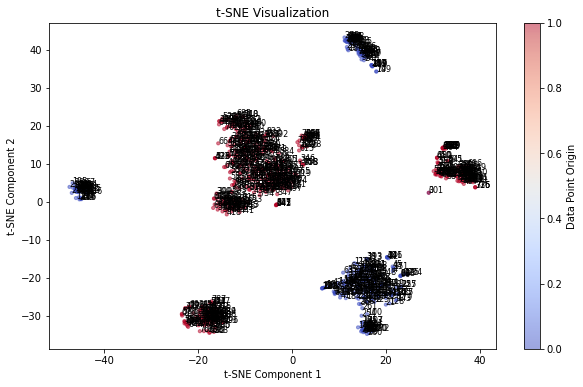

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def euclidean_distance(v1, v2):
    """
    Calculate the Euclidean distance between two vectors.
    
    Args:
    v1 (array-like): First vector.
    v2 (array-like): Second vector.
    
    Returns:
    float: Euclidean distance between v1 and v2.
    """
    return np.linalg.norm(v1 - v2)

def average_euclidean_distance(file1, file2):
    """
    Calculate the average Euclidean distance between records in two files.
    
    Args:
    file1 (str): Path to the first CSV file.
    file2 (str): Path to the second CSV file.
    
    Returns:
    float: Average Euclidean distance between records in the two files.
    """
    df1 = pd.read_csv(file1, header=None)  # Read the first CSV file
    df2 = pd.read_csv(file2, header=None)  # Read the second CSV file

    # Calculate Euclidean distances between corresponding records
    distances = [euclidean_distance(np.array(row1), np.array(row2))
                 for row1, row2 in zip(df1.values, df2.values)]
    
    # Calculate the average distance
    avg_distance = np.mean(distances)
    
    return avg_distance

def visualize_with_index(file1, file2):
    """
    Visualize data points using t-SNE and show the index of each data point.
    
    Args:
    file1 (str): Path to the first CSV file.
    file2 (str): Path to the second CSV file.
    """
    df1 = pd.read_csv(file1, header=None)  # Read the first CSV file
    df2 = pd.read_csv(file2, header=None)  # Read the second CSV file
    
    # Combine two dataframes
    df_combined = pd.concat([df1, df2], axis=0)
    
    # Create labels for points (0 for file1, 1 for file2)
    labels = [0] * len(df1) + [1] * len(df2)
    
    # Apply t-SNE to reduce dimensions
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(df_combined)
    
    # Plot data points
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='coolwarm', s=10, alpha = 0.5)  # Specify colors and sizes
    for i, point in enumerate(tsne_data):
        plt.text(point[0], point[1], str(i), fontsize=8)  # Display index of each point
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('t-SNE Visualization')
    plt.colorbar(label='Data Point Origin')
    plt.show()

# Paths to the CSV files
file1_path = "Client_smashed_data.csv"
file2_path = "Dictionary_smashed_data.csv"

# Calculate the average Euclidean distance
avg_dist = average_euclidean_distance(file1_path, file2_path)
print("Average Euclidean distance between records:", avg_dist)

# Visualize data points with index using t-SNE
visualize_with_index(file1_path, file2_path)
